# Telekom/emetriq Data Challenge

In [1]:
#Import der benötigten Pakete
import pandas as pd 
import numpy as np
import datetime
from pandasql import sqldf
import matplotlib.pyplot as plt

pysqldf = lambda q: sqldf(q, globals())

Einlesen der Daten mit panda:

In [2]:
df_labels = pd.read_csv("C:\\Users\gkrause\Desktop\python\data\labels.csv")
df_labels.head()

,profile_id\tis_man
0,1339524189722010100020162000012966\t1
1,1339524189722010100020162000012966\t1
2,1339524189722010100020162000012966\t1
3,1343739999827010100020010000012966\t0
4,1348681828483010100022063000007393\t0


In [3]:
df_labels = pd.read_csv("C:\\Users\gkrause\Desktop\python\data\labels.csv" ,sep = '\t')
df_impressions = pd.read_csv("C:\\Users\gkrause\Desktop\python\data\page_impressions.csv" ,sep = '\t')

#df_labels.head()
df_impressions.head()

,profile_id,ua_lang,url,user_agent,timestamp
0,1338307099035010250219044000006465,de,https://www.focus.de:80/gesundheit/news/verunr...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,1534235537743
1,1339524189722010100020162000012966,de,https://immo.rheinpfalz.de:80/immobilien/baugr...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:61...,1534437594586
2,1339524189722010100020162000012966,de,https://immo.rheinpfalz.de:80/immobilien/baugr...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:61...,1534437594586
3,1339524189722010100020162000012966,de,https://www.tvnow.de:80/rtl/denn-sie-wissen-ni...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:61...,1534660973598
4,1339524189722010100020162000012966,de,https://www.tvnow.de:80/rtl/guten-morgen-deuts...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:61...,1534188943263


Welches Format besitzt das TIMESTAMP-Attribut?

In [ ]:
#type(df_impressions.timestamp[3])
len(str(df_impressions.timestamp[3]))

Dank Internetsuche herausgefunden: Millisekunden seit dem 01.01.1970 (meistens von UNIX)

In [ ]:
timestamp = df_impressions.timestamp[3]
timestamp_new = df_impressions.timestamp[3]-1000

zeit_alt = datetime.datetime.fromtimestamp(int(timestamp)/1000)
zeit_neu = datetime.datetime.fromtimestamp(int(timestamp_new)/1000)
print("Die alte Zeit:")
print(zeit_alt.strftime("%Y-%m-%d %H:%M:%S")) 
print("Die neue Zeit:")
print(zeit_neu.strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
df_labels.info()

Beispiel für ein Duplikat

In [ ]:
#df_labels.groupby(['profile_id','is_man']).size()
df_labels[df_labels['profile_id']=='1348681828483010100022063000007393']

Duplikate löschen

In [4]:
df_labels_dist=df_labels.drop_duplicates(['profile_id','is_man'], keep='first')
#df_labels_dist[df_labels_dist['profile_id']=='1348681828483010100022063000007393']
#df_labels_dist.info()

Schwierigkeit beim Idenifizieren der Duplikate aufgrund der TIMESTAMP-Range, deswegen Rank-Bildung.

In [5]:
#Sortieren von Datensatz
df_impressions_sort=df_impressions.sort_values(by=['profile_id','url','timestamp'])

a = """
    SELECT
         profile_id, ua_lang, url, user_agent, timestamp, 
             row_number() over(partition by profile_id, url order by  timestamp asc ) as rank,
             case when lead(timestamp) over(partition by profile_id, url) <> 'NaN' then
             (lead(timestamp) over(partition by profile_id, url)  - timestamp) end as diff
     FROM
        df_impressions_sort 
     ;"""
           
df_sql_rank = pysqldf(a)
#print(df_sql_rank[['profile_id','url','timestamp','rank', 'time_lead']])

In [ ]:
#df_sql_rank[df_sql_rank['rank']==4]
#df_sql_rank[df_sql_rank['profile_id']=='1349981668727010100020153000012141']
#df_sql_rank[(df_sql_rank['diff'] < 1000) & (df_sql_rank['diff'] > 1)]

Nimm alle Zeilen mit Rank = 1 und join diese Tabelle mit allen Zeilen die Rank >1 besitzen.

In [6]:
r1 = """
     SELECT
         profile_id, ua_lang, url, user_agent, timestamp
     FROM
        df_sql_rank
    where rank = 1
     ;"""
           
df_sql_rank1 = pysqldf(r1)
#print(df_sql_rank1)

r2 = """
     SELECT
         profile_id, ua_lang, url, user_agent, timestamp
     FROM
        df_sql_rank
    where rank > 1
     ;"""
           
df_sql_rank2 = pysqldf(r2)
#print(df_sql_rank2)

q = """SELECT
       distinct   m.profile_id, m.ua_lang, m.url, m.user_agent, m.timestamp as timestamp_r1, b.timestamp as timestamp_r2,  
           case when ( m.timestamp -b.timestamp) between -1000 and 1000 then 1 else 0 end as diff
     FROM
        df_sql_rank1 m
     INNER JOIN
        df_sql_rank2 b
           ON m.profile_id = b.profile_id and m.url= b.url
           order by 1,3;"""
           
joined = pysqldf(q)
#print(joined)

Nur die Zeilen nehmen, deren Timestamp-Differenz unter 1000 ist, TIMESTAMP - Attribut aus r2 nehmen. 

In [7]:
b = """SELECT
       distinct  profile_id, ua_lang, url, user_agent, timestamp_r2 as timestamp
     FROM
        joined 
     WHERE diff = 0;
    """
           
df_diff = pysqldf(b)
#print(df_diff)

#Append der Tabellen
df_impressions_dst=df_sql_rank1.append(df_diff).sort_values(by=['profile_id','url','timestamp'])

Überprüfung der Tabelle

In [8]:
df_impressions_dst[df_impressions_dst['profile_id']=='1348681828483010100022063000007393']
#df_impressions_dst.info()

,profile_id,ua_lang,url,user_agent,timestamp
17,1348681828483010100022063000007393,de,https://www.t-online.de:80/?ref=overscroll,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534797562126
18,1348681828483010100022063000007393,de,https://www.t-online.de:80/?utm_campaign=tonli...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534022893143
3,1348681828483010100022063000007393,de,https://www.t-online.de:80/?utm_campaign=tonli...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534060313847
4,1348681828483010100022063000007393,de,https://www.t-online.de:80/?utm_campaign=tonli...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534363795108
5,1348681828483010100022063000007393,de,https://www.t-online.de:80/?utm_campaign=tonli...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534435676682
6,1348681828483010100022063000007393,de,https://www.t-online.de:80/?utm_campaign=tonli...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534584888993
7,1348681828483010100022063000007393,de,https://www.t-online.de:80/?utm_campaign=tonli...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534709701259
8,1348681828483010100022063000007393,de,https://www.t-online.de:80/?utm_campaign=tonli...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534883677308
19,1348681828483010100022063000007393,de,https://www.t-online.de:80/sport/live-ticker/f...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534536050228
20,1348681828483010100022063000007393,de,https://www.t-online.de:80/tv/webclips/id_8427...,Mozilla/5.0 (Windows NT 6.0; rv:52.0) Gecko/20...,1534190415078


Als csv-Datei speichern

In [ ]:
df_labels_dist.to_csv("C:\\Users\gkrause\Desktop\python\data\labels_final.csv" ,sep = '\t')
df_impressions_dst.to_csv("C:\\Users\gkrause\Desktop\python\data\impressions_final.csv" ,sep = '\t')

Vielleicht zu komplex gedacht?

In [ ]:
#df_test=df_impressions_sort.drop_duplicates(['profile_id','url','timestamp'], keep='first')
#df_test.info()

Task 2: page_impressions und labels mittels inner Join zusammenführen.

In [9]:
df_ml=df_impressions_dst.merge(df_labels_dist, on='profile_id', how='inner')
df_ml.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8577 entries, 0 to 8576
Data columns (total 6 columns):
profile_id    8577 non-null object
ua_lang       8577 non-null object
url           8577 non-null object
user_agent    8577 non-null object
timestamp     8577 non-null int64
is_man        8577 non-null int64
dtypes: int64(2), object(4)
memory usage: 469.1+ KB


(array([589.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 131.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

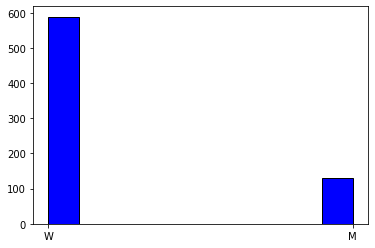

In [11]:
df_ml['geschlecht']  = df_ml['is_man'].apply(lambda x: 'W' if (x == 0) else 'M')
df_telekom=df_ml[df_ml['url'].str.contains('www.t-online.de')]
df_telekom_hist=df_telekom.drop_duplicates(['profile_id','is_man'], keep='first')

plt.hist(df_telekom_hist['geschlecht'], color = 'blue', edgecolor = 'black')